In [1]:
"""install the packages to run this code"""
#%pip install matplotlib tifffile scipy tqdm pybaselines

'install the packages to run this code'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
#import cv2
#from PIL import Image
#from pybaselines.whittaker import asls
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from scipy.signal import cheby1, filtfilt, find_peaks, peak_widths
from tqdm import tqdm

In [3]:
video = "//files.ubc.ca/team/BNRC/NINC/Raymond Lab/Kaiiiii/cortical data/Pilot/2023_11_01/405700_f3_stage2_pilot_day3_violet.tif"
#video = "//files.ubc.ca/team/BNRC/NINC/Raymond Lab/Kaiiiii/ortical data/2023_09_05-13_grant/2023_09_06/405700_f1_stage2_day2(1).tif"

In [4]:
def load_frames(video):
    """
    Loads in tif stacks as a 3d array. Make sure the dtype is 12.
    :param video: path to the file, including file name.tif

    :return: 3d array of 128x128 x timeseries
    """

    print("loading video, please wait...")
    frames = tifffile.imread(video)
    print("dimensions are", frames.shape, "as a", frames.dtype)
    return frames

In [5]:
frames = load_frames(video);

loading video, please wait...
dimensions are (18133, 128, 128) as a uint16


In [312]:
def plot_frame(frames:np.ndarray, frame_number, cmap = 'jet', color_label = "N/A"):
    """
    plots a frame of interest, to check if the video was loaded in properly
    :param frames: 3d array loaded in with tifffile
    :param frame_number: frame of interest to plot
    :param cmap: colormap used, set to jet as default
    """

    image = frames[frame_number, :, :]
    fig, ax = plt.subplots()
    im = ax.imshow(image, cmap=cmap)
    plt.colorbar(im, label = color_label)
    ax.grid(True)
    ax.axis('on')
    print("frame number", frame_number, "plotted")
    plt.show()

frame number 5000 plotted


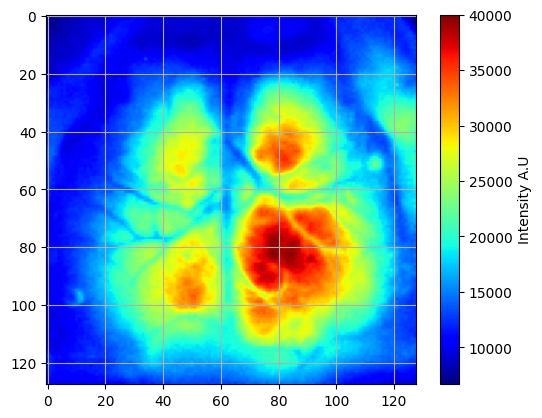

In [314]:
plot_frame(frames, 5000, color_label = "Intensity A.U")

In [284]:
def temporal_mean(frames):
    """
    calculate and plot the signal over time
    
    :param frames: 3d array loaded in with tifffile
    :return: 1d array where each frame intensity is averaged
    """
    
    mean_timecourse = frames.mean(axis=(1,2))

    min_value = np.min(mean_timecourse)     # Find the minimum value in the signal array
    dark_frame_threshold = min_value + 0.2 * min_value     # Calculate the threshold as the minimum value plus 10%

    #plotting
    print("default 20% threshold is", dark_frame_threshold, "Determine if adjustments need to be made")
    plt.plot(mean_timecourse)
    plt.title("mean timecourse")
    plt.xlabel("frame number (30 fps)")
    plt.ylabel("intensity value (A.U)")
    
    plt.show()
    return mean_timecourse

default 20% threshold is 6329.5828125 Determine if adjustments need to be made


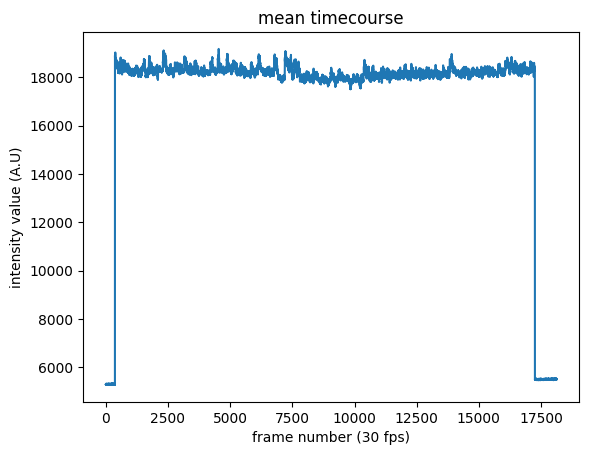

In [285]:
mean_timecourse = temporal_mean(frames);

In [287]:
def remove_dark_frames(frames, signal, threshold = 0.2):
    """
    calculate where the dark frames are at the start and end of the trial

    :param frames: 3d array loaded in with tifffile
    :param signal: 1d array mean_time course array
    :param threshold: a percent above the minimum value, default set to 20%

    return: 
    """
    
    min_value = np.min(signal)     # Find the minimum value in the signal array
    dark_frame_threshold = min_value + threshold * min_value     # Calculate the threshold as the minimum value plus 10%
    
    brain_indices = np.where(signal > dark_frame_threshold)[0]
    start_index = brain_indices[0]+1
    end_index = brain_indices[-1]
    
    frames = frames[start_index:end_index, :, :]
    signal = signal[start_index:end_index]

    #plotting
    print("threshold determined to be:", dark_frame_threshold)
    plt.plot(signal)
    plt.title("mean timecourse with dark frames removed")
    plt.xlabel("frame number (30 fps)")
    plt.ylabel("intensity value (A.U)")
    
    return signal, frames

threshold determined to be: 5802.117578125


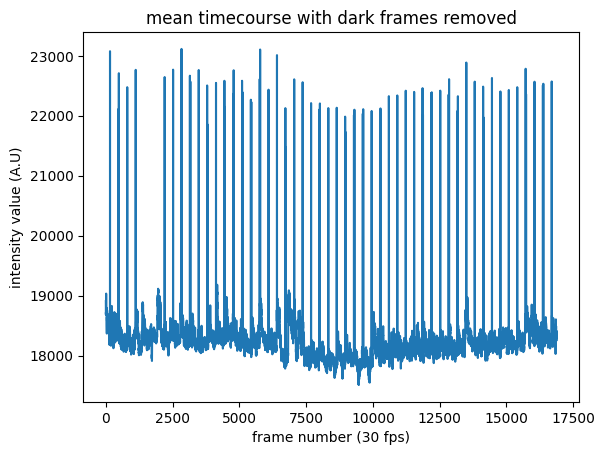

In [20]:
darkf_removed = remove_dark_frames(frames, mean_timecourse, 0.1)
darkf_removed_timecourse = darkf_removed[0]
darkf_removed_frames = darkf_removed[1]

In [40]:
def extract_artifacts(timecourse, frames_between_double_flash = 20):
    """
    extract indices where the artifact flash exists, as a function of 3 times the standard deviation of the global mean
    :param timecourse: 1d array of the mean time course
    :param frames_between_double_flash: the set time between two flashes in the double flash condition, default set to 20, always estimate higher

    :return: array of where the signal is above the mean, artifact flashes
    """

    T_mean = timecourse.mean()
    std = timecourse.std()
    artifact_indices = find_peaks(timecourse, height=(T_mean + 3 * std), distance=10)[0] #indescriminatly finds all the flashes

    """ THIS PART IS FOR USE WHEN NEEDING TO SEPARATE SINGLE AND DOUBLE"""
    time_diff = np.diff(artifact_indices) #determine the time between each peak, if it is 15 frames it is double, 320 frames is single

    single_flash = []
    double_flash = []

    for i in range(len(artifact_indices)):
        is_double_peak = (i > 0 and artifact_indices[i] - artifact_indices[i - 1] < frames_between_double_flash) or \
                         (i < len(artifact_indices) - 1 and artifact_indices[i + 1] - artifact_indices[i] < frames_between_double_flash)
        if is_double_peak:
            double_flash.append([artifact_indices[i], artifact_indices[i-1]])
        else:
            single_flash.append(artifact_indices[i])
        
    print("Number of double_flash:", len(double_flash))
    print("Number of single_flash:", len(single_flash))
    print("Number of total flashes:", len(artifact_indices))

    """SECTION END"""
    
    return artifact_indices #,single_flash, double_flash

In [41]:
artifact_indices = extract_artifacts(darkf_removed_timecourse)

Number of double_flash: 42
Number of single_flash: 29
Number of total flashes: 71


In [292]:
def interpolate(no_dark_frames, artifact_indices):
    """
    interpolate over the artifacts, representing a total of 5 frames. 

    :param frames: 3d array with dark frames removed, DO NOT USE ORIGINAL "FRAMES" (includes each pixel value over time)
    :param artifact_indices: index of where the artifact are located in the frames array
    

    :return: 
    """
    
    print("interpolating artifact frames...")
    interp_indices = []        #make the indices that need to be interpolated, organized in groups of 5
    for index in artifact_indices:
        start = index-3        #add 3 frame padding before, to ensure the entire artifact is removed
        end = index+3          #add 3 frame padding after, to ensure the entire artifact is removed
        group = []
        for new_index in range(start, end+1):        #loop within to ensure each array within the array is a total of 7 (for each flash of light)
            group.append(new_index)
        interp_indices.append(group)

    x = [0, 6]                                                                  #between the two interpolated side, split into equaL segments
    xnew = np.linspace(0, 6, np.shape(interp_indices)[1])                       #linear interpolate between the two x values, at equal increments
    for g in tqdm(range(len(interp_indices[:]))):                                                 #tqdm is loading package (GUI), loops 3 dimensions of array
        y_2d = [no_dark_frames[interp_indices[g][0]], no_dark_frames[interp_indices[g][-1]]]      #the frames which are usable on either side of artifact
        for r in range(no_dark_frames.shape[1]):                                                  #iterate over each row of pixels
            for c in range(no_dark_frames.shape[2]):                                              #iterate over each column of pixels
                y = [y_2d[0][r, c], y_2d[1][r, c]]                              #represents each pixel [r,c], and the first and last frame to interpolate between
                f = interp1d(x, y)                                              #interpolate the y values between these two-time segments
                ynew = f(xnew)
                no_dark_frames[interp_indices[g], r, c] = ynew[:]

    #plot the interpolation
    plt.figure()
    plt.plot(no_dark_frames.mean(axis=(1,2)))
    plt.title("mean timecourse with without artifacts")
    plt.xlabel("frame number (30 fps)")
    plt.ylabel("intensity value (A.U)")

    return no_dark_frames

interpolating artifact frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [01:53<00:00,  1.60s/it]


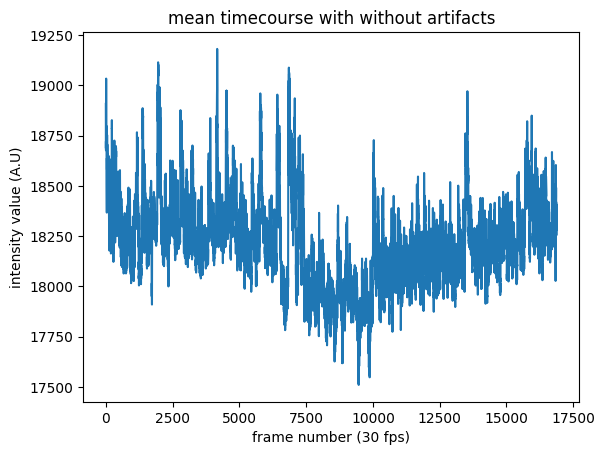

In [293]:
no_artifact_timecourse = interpolate(darkf_removed_frames, artifact_indices)

In [250]:
def dff(data, duration = 10, frame_rate = 30, eps=1e-3):
    """
     Calculate dF/F (moving centered mean) for tif video data.

    :param data: 3d array with shape (depth, height, width), use the no artifact array
    :param duration: Duration over which to average in seconds, default set at 10
    :param frame_rate: Frame rate of the data in frames per second, default set at 30fps

    :return: 3d array including the padding on both ends
    """
    num_frames = int(duration * frame_rate)
    
    pad_size = int(num_frames / 2)
    depth, height, width = data.shape[0], data.shape[1], data.shape[2]          # initialize the result array
    dFF = np.ones((depth + 2 * pad_size, height, width), dtype=np.float32)
    centered_mean_array = np.zeros_like(data)

    data = np.concatenate((np.ones((pad_size, height, width)), data), axis=0)  # add padding to the data array (required for mean calculation)
    data = np.concatenate((data, (np.ones((pad_size, height, width)))), axis=0)
    for h in tqdm(range(height)):
        for w in range(width):
            data[0:pad_size,h,w] = data[pad_size:pad_size*2,h,w].mean()      #for each pixel (h=height, w=width), replace the start padding with the mean of the first 10 seconds
            data[-pad_size:,h,w] = data[-pad_size*2:-pad_size,h,w].mean()

    # iterate over frames starting from num_frames
    for t in tqdm(range(pad_size, depth+pad_size)):        # t starts at pad_size (the adjusted index 0 after padding)
        current_frame = data[t, :, :]        # get the current frame
        centered_mean = np.mean(data[(t - pad_size):(t + pad_size), :, :], axis=0)       # calculate the centered mean with respect to the current frame (t)
        centered_mean_array[t-pad_size,:,:] = centered_mean       #need subtract pad_size because the centered_mean_array does not include the padding      
        dF = current_frame - centered_mean               # calculate dF
        dFF[t, :, :] = (dF / (centered_mean + eps))              # calculate dF/F and store in the result array

    #plotting
    return dFF[pad_size:-pad_size, :, :], centered_mean_array

In [251]:
dff_array = dff(no_artifact_timecourse, 10, 30);
dff_signal = dff_array[0]
moving_average = dff_array[1]

100%|███████████████████████████████████████████████████████████████████████████| 16885/16885 [01:22<00:00, 205.83it/s]


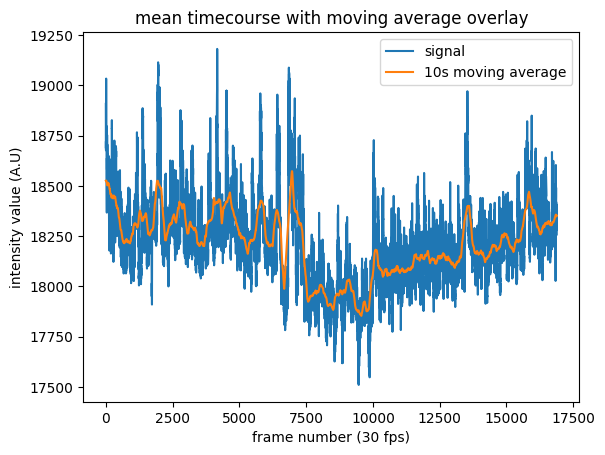

In [296]:
#plotting mean and interpolated intensity
plt.figure()
plt.plot(no_artifact_timecourse.mean(axis=(1,2)))
plt.plot(moving_average.mean(axis=(1,2)))
plt.title("mean timecourse with moving average overlay")
plt.xlabel("frame number (30 fps)")
plt.ylabel("intensity value (A.U)")
plt.legend(["signal","10s moving average"])

Text(0, 0.5, 'dff')

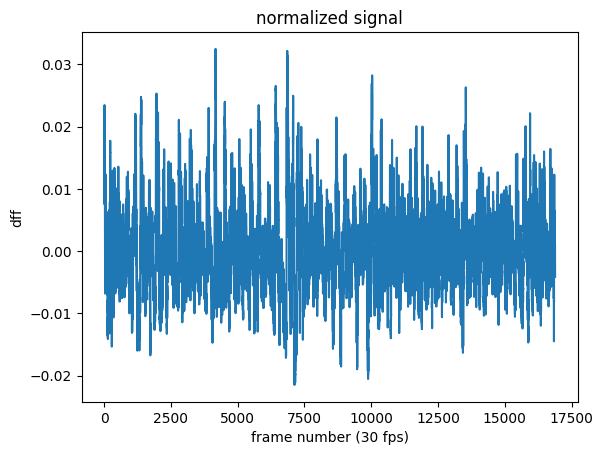

In [297]:
#plotting dff
plt.figure()
plt.plot(dff_signal.mean(axis=(1,2)))
plt.title("normalized signal")
plt.xlabel("frame number (30 fps)")
plt.ylabel("dff")

frame number 5000 plotted


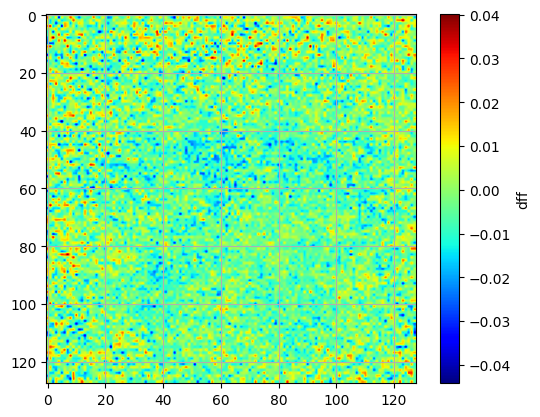

In [315]:
non_smoothed = plot_frame(dff_signal, 5000, color_label = "dff")      #plt.imshow(dff_signal[2000]) is another way to plot

In [ ]:
def temporal_filter

In [ ]:
def apply_temporal_filters(data: np.ndarray) -> np.ndarray:
    """
    Smooth the data using a Gaussian filter for the spatial dimension and
    Chebyshev filter for the temporal dimension. Optionally, add the mean
    value of the data to the result.

    :param data: The dff 3d array with shape (depth, height, width)
    :param boost: Add the mean value of the data to the result

    :return: Normalized 3d array with shape (depth, height, width)
    """

    # smooth the data using a Gaussian filter for the spatial dimension
    data = gaussian_filter(data, sigma=2.0, radius=3)  # values requested by KT

    # smooth the data using a Chebyshev filter for the temporal dimension
    fs = 30.0  # sampling frequency
    Ny = 0.5 * fs  # Nyquist frequency

    lp = 0.1  # lower bound of the desired frequency band
    hp = Ny - 0.001  # upper bound of the desired frequency band

    # design the Chebyshev type I filter (see SciPy documentation for details)
    chebyshev = cheby1(N=2,
                       rp=0.5,
                       Wn=[lp / Ny, hp / Ny],
                       btype='band',
                       analog=False,
                       output='ba')

    # initialize the result array
    result = np.empty_like(data)

    # apply the filter along the time axis to each pixel (temporal dimension)
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            result[:, i, j] = filtfilt(b=chebyshev[0], a=chebyshev[1], x=data[:, i, j])

    # normalize the result
    result = (result - result.min()) / (result.max() - result.min())
    np.clip(result, 0, 1)  # clip values to be between 0 and 1

    return result